In [1]:
import sys
from library_analyzer import Library, PlottingContext
import numpy as np
np.bool = np.bool_
from mavenn import Model

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import seaborn as sns
from matplotlib import rc_context

from scipy.stats import ttest_1samp, false_discovery_control, gaussian_kde



# Setup plotting defaults

In [2]:
defaults = {}
defaults['axes.linewidth'] = 0.25
defaults['grid.linewidth'] = 0.25
defaults['lines.linewidth'] = 0.5
defaults['lines.markersize'] = 1
defaults['patch.linewidth'] = 0.25

defaults['xtick.major.width'] = 0.25
defaults['ytick.major.width'] = 0.25
defaults['xtick.minor.width'] = 0.25
defaults['ytick.minor.width'] = 0.25

defaults['xtick.major.size'] = 1
defaults['ytick.major.size'] = 1
defaults['xtick.minor.size'] = 0.75
defaults['ytick.minor.size'] = 0.75

defaults['font.size'] = 6
defaults['axes.labelsize'] = 6
defaults['axes.titlesize'] = 6
defaults['xtick.labelsize'] = 6
defaults['ytick.labelsize'] = 6
defaults['legend.fontsize'] = 6
defaults['legend.title_fontsize'] = 6
defaults

{'axes.linewidth': 0.25,
 'grid.linewidth': 0.25,
 'lines.linewidth': 0.5,
 'lines.markersize': 1,
 'patch.linewidth': 0.25,
 'xtick.major.width': 0.25,
 'ytick.major.width': 0.25,
 'xtick.minor.width': 0.25,
 'ytick.minor.width': 0.25,
 'xtick.major.size': 1,
 'ytick.major.size': 1,
 'xtick.minor.size': 0.75,
 'ytick.minor.size': 0.75,
 'font.size': 6,
 'axes.labelsize': 6,
 'axes.titlesize': 6,
 'xtick.labelsize': 6,
 'ytick.labelsize': 6,
 'legend.fontsize': 6,
 'legend.title_fontsize': 6}

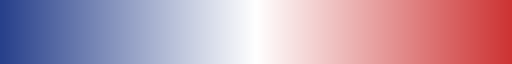

In [3]:
rc_defaults = {
   "font.family" : 'sans-serif',
   "font.sans-serif" : 'Helvetica',
   'figure.autolayout' :  True,
   "figure.figsize" : (1.4,1.4),
   "figure.dpi": 400
}

rc_double_wide = rc_defaults.copy()
rc_double_wide["figure.figsize"] = (3.4,1.4)

# with rc_context(rc_double_wide):


sns.set_context(defaults, rc = rc_defaults)
plt.rcParams.update(rc_defaults)


grey_cmap = sns.blend_palette(['0.8','0.2'],as_cmap=True)
to_blue_cmap = sns.blend_palette(['#9FB6CD','#27408B'],as_cmap=True)
heatmap_cmap = sns.blend_palette(['#9FB6CD','xkcd:white','#CD3333'],as_cmap=True)
alt_heatmap_cmap = sns.blend_palette(['#27408B','xkcd:white','#CD3333'],as_cmap=True)

alt_heatmap_cmap

In [4]:
def make_density(x):
    if len(x)<2:
        density = pd.Series(np.ones((len(x))))
    else:
        density = pd.Series(gaussian_kde(x).evaluate(x))
    density.index=x.index
    return(density)


def ttester(x):
    pvals = ttest_1samp(x,0).pvalue
    return(pvals)

wts = {'TRF_perfect':'TGGCGCCCGAACAGGGACTTGA',#+'AGAATGGCAGAGAGATGCTAAGAGGA', 
       'Josh_match':'TGGCGCCCGAACAGGGACCTGA',#+'AGAATGGCAGAGAGATGCTAAGAGGA',
       'Native_MusD6':'TGGCGCCAGAACTGGGACCTGA',#+'AGAATGGCAGAGAGATGCTAAGAGGA'}
}

# Load data

In [5]:
lib = Library.load('../data/processed/allNOindel_1PBS_seq_MPRA.lib.pkl')

In [6]:
negative_ctrls = pd.read_csv('../data/negcontrol.txt', header=None).values.flatten()
negative_ctrls

array(['CTAGCGACTAAACACATCAA', 'GGATCCGACTAAACACATCAA',
       'AATCGGCGACTAAACACATCAA', 'TCATGAGCGACTAAACACATCAA',
       'GCCTAAGCCGACTAAACACATCAA', 'TTAAGGCTATGAAGAGATAC',
       'CGTATAGCTATGAAGAGATAC', 'AGACTAAGCTATGAAGAGATAC',
       'TCAGATAAGCTATGAAGAGATAC', 'CAGTACAAAGCTATGAAGAGATAC',
       'CATGTATTGGCCTGTATTAG', 'GTCAGTATTGGCCTGTATTAG',
       'TCATGATATTGGCCTGTATTAG', 'AGTGACATATTGGCCTGTATTAG',
       'ACAGTGCATATTGGCCTGTATTAG', 'TATGAACGTGAATTGCTCAA',
       'GGAATAACGTGAATTGCTCAA', 'CATAAGAACGTGAATTGCTCAA',
       'CTAGAAACACGTGAATTGCTCAA', 'GGTACAAACACGTGAATTGCTCAA',
       'AGTCCAGGGACAAGCCCGCGGT', 'AACTACACAAATCAGCGGCTAA',
       'CATAGAGAAGTATCGAATCAGA', 'GATTATGTCCGGTTATAGTACT',
       'AACTCGTTAAGTGCAAGAATAC', 'TAGCGACTAAACACATCACTGA',
       'TCAGGTCCCTGTTCGGGCGCCA', 'AAGTTTTCACTCCAGCTAACAG',
       'GGGGCTACGTCCAGGAGCGCAT', 'CATTCTACCCACTCGAAGACGG',
       'GCGCTCACCAGGCACGGAGAGT', 'GGACGCAGGACCGCCAACTGGT',
       'GACCGCACGACGGCCAAGGTGT', 'GCGGCACGACCGGGACCATAGT

# Make MAVENN heatmap

,sequence,to_ignore,variable,Observed_value
0,TGACTCCCGAACAGGGACCTGA,False,l10fc pool1_RNA1500,0.030172
1,TGGCGCGGCAATCCGGACCTGA,False,l10fc pool1_RNA1500,0.035524
2,TGGTAGCAGAGGATGGTTTCGA,False,l10fc pool1_RNA1500,-0.044696
3,TGGCTACCGAACAGGGACCTGA,False,l10fc pool1_RNA1500,0.005999
4,TGACACCTGAACAGGGACTGAG,False,l10fc pool1_RNA1500,-0.048867
...,...,...,...,...
1060,TGGCGCCCGAACAGGGACACCG,False,l10fc pool3_RNA1500,-0.044536
1061,TGGCGCCCGAACAGGGCTCTGA,False,l10fc pool3_RNA1500,-0.012672
1062,GATTTGCCGAACAGGGACCTGA,False,l10fc pool3_RNA1500,0.087249
1063,GAATATGCGAACAGGGACCTGA,False,l10fc pool3_RNA1500,0.023464


,sequence,to_ignore,valid,replicate,Observed_value
0,GCTCAGGCGAACAGGGACCTGA,False,True,l10fc pool1_RNA1500,0.030811
1,TGGCGCCCGTTAAGGGACCTGA,False,True,l10fc pool1_RNA1500,-0.004470
2,CAGCGCCCGAACAGGGACCTGA,False,True,l10fc pool1_RNA1500,0.049097
3,TATAAGCCGAACAGGGACCTGA,False,True,l10fc pool1_RNA1500,-0.002706
4,TGGAGCCTGAGCAGGGACATGT,False,True,l10fc pool1_RNA1500,-0.035936
...,...,...,...,...,...
4264,TGCCCCCAGAACAGGGACACAA,False,False,l10fc pool3_RNA1500,-0.109336
4265,TGGCACCTAAACAGGGACACGG,False,False,l10fc pool3_RNA1500,-0.013122
4266,TGGTGCCTGAACAGGGACCTGA,False,False,l10fc pool3_RNA1500,0.017972
4267,TGGCGCCATTACAGGGACCTGA,False,False,l10fc pool3_RNA1500,0.000492


N = 4,269 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0741 sec.
Training time: 2.2 seconds
Model saved to these files:
	../data/processed/MAVENN_model.ckpt.pickle
	../data/processed/MAVENN_model.ckpt.h5
test_I_var: 0.322 +- 0.062 bits
test_I_pred: 0.491 +- 0.024 bits


/Users/jackdesmarais/miniconda3/envs/TRf_transposon_silencing_MPRA/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


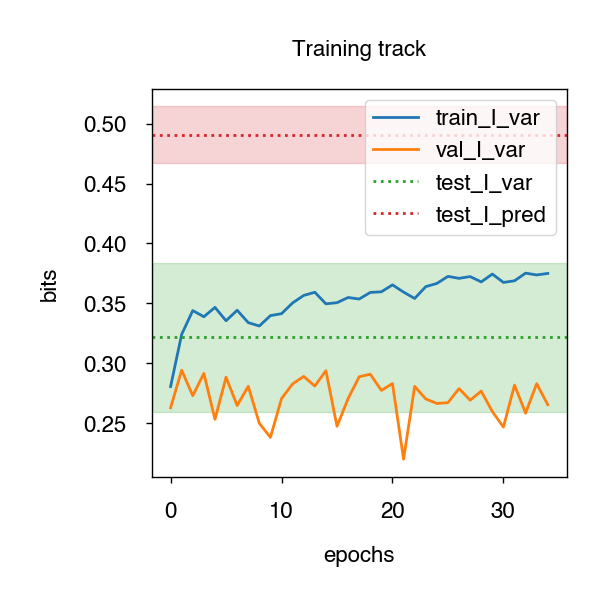

/Users/jackdesmarais/miniconda3/envs/TRf_transposon_silencing_MPRA/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


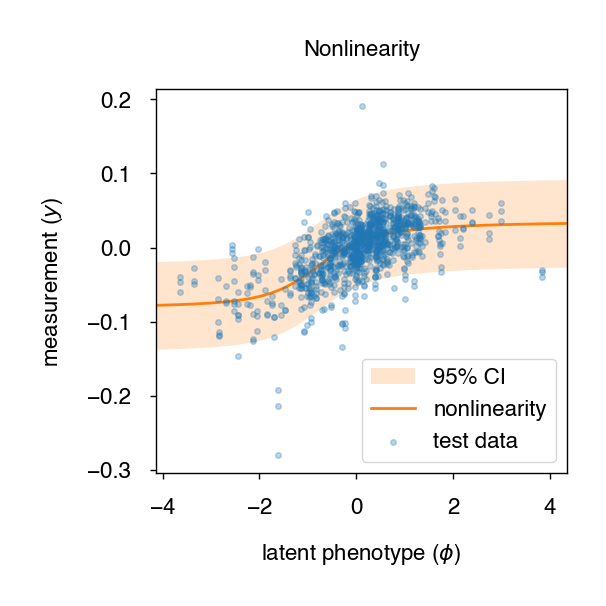

/Users/jackdesmarais/miniconda3/envs/TRf_transposon_silencing_MPRA/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


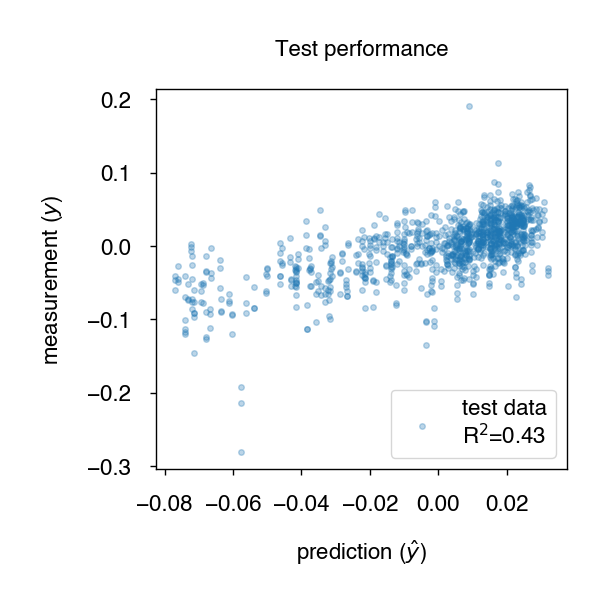

In [7]:
maven_plotting_defaults = defaults.copy()

maven_plotting_defaults['font.size'] = 4
maven_plotting_defaults['axes.labelsize'] = 4
maven_plotting_defaults['axes.titlesize'] = 4
maven_plotting_defaults['xtick.labelsize'] = 4
maven_plotting_defaults['ytick.labelsize'] = 4
maven_plotting_defaults['legend.fontsize'] = 4
maven_plotting_defaults['legend.title_fontsize'] = 4

with PlottingContext(sns_settings=maven_plotting_defaults, rc_settings=rc_defaults):
        target_df = lib.fitness_frame

        target_reps = ['pool1_RNA1500', 'pool2_RNA1500', 'pool3_RNA1500']
        target_cols = [lib.fitness_measure+' '+rep for rep in target_reps]

        seqs_to_ignore = negative_ctrls


        target_df['to_ignore'] = target_df['sequence'].isin(seqs_to_ignore)

        split_arr = np.random.default_rng(42).permutation(target_df.index)
        test_frac = 0.2
        test_df = target_df.loc[split_arr[:int(len(target_df)*test_frac)]]
        test_df = test_df.melt(id_vars=['sequence','to_ignore'],value_vars=target_cols, value_name='Observed_value')
        test_df = test_df.rename(columns={('sequence'):'sequence',
                        'variable_0':'replicate',
                        'variable_1':'to_ignore'})
                        
        display(test_df)
        tv_idx = split_arr[int(len(target_df)*test_frac):]
        train_val = target_df.loc[tv_idx]
        train_val['valid'] = False
        train_val.loc[tv_idx[:int(len(tv_idx)*test_frac)],'valid'] = True
        train_val = train_val.melt(id_vars=['sequence','to_ignore', 'valid'],value_vars=target_cols, value_name='Observed_value')
        train_val = train_val.rename(columns={
                        'variable':'replicate'})
        display(train_val)

        model = Model(L=len(lib.WT_seq), alphabet='dna', regression_type='GE', gpmap_type='additive')
        model.set_data(x=train_val['sequence'].values,
                        y=train_val['Observed_value'].values,
                        validation_flags=train_val['valid'].values)
        model.fit(verbose=False)
        model.save(f'../data/processed/MAVENN_model.ckpt')

        I_var, dI_var =  model.I_variational(x=test_df['sequence'], y=test_df['Observed_value'])
        print(f'test_I_var: {I_var:.3f} +- {dI_var:.3f} bits')

        I_pred, dI_pred = model.I_predictive(x=test_df['sequence'], y=test_df['Observed_value'])
        print(f'test_I_pred: {I_pred:.3f} +- {dI_pred:.3f} bits')


        fig = plt.figure(layout='constrained')

        # Plot I_var_train, the variational information on training data as a function of epoch
        plt.plot(model.history['I_var'],
                label=r'train_I_var')

        # Plot I_var_val, the variational information on validation data as a function of epoch
        plt.plot(model.history['val_I_var'],
                label=r'val_I_var')

        # Show I_var_test, the variational information of the final model on test data
        plt.axhline(I_var, color='C2', linestyle=':',
                label=r'test_I_var')
        plt.axhspan(I_var-dI_var, I_var+dI_var,color='C2',alpha=0.2)

        # Show I_pred_test, the predictive information of the final model on test data
        plt.axhline(I_pred, color='C3', linestyle=':',
                label=r'test_I_pred')
        plt.axhspan(I_pred-dI_pred, I_pred+dI_pred,color='C3',alpha=0.2)

        # Style plot
        plt.xlabel('epochs')
        plt.ylabel('bits')
        plt.title(f'Training track')
        plt.legend()
        plt.show()

        fig = plt.figure(layout='constrained')

        phi_test = model.x_to_phi(test_df['sequence'])
        ## Set phi lims and create a grid in phi space
        phi_lim = [min(phi_test)-.5, max(phi_test)+.5]
        phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

        # Compute yhat for each phi gridpoint
        yhat_grid = model.phi_to_yhat(phi_grid)

        # Compute 95% CI for each yhat
        q = [0.025, 0.975]
        yqs_grid = model.yhat_to_yq(yhat_grid, q=q)

        # Plote 95% confidence interval
        plt.fill_between(phi_grid, yqs_grid[:, 0], yqs_grid[:, 1],
                        alpha=0.2, color='C1', lw=0, label='95% CI')

        # Plot GE nonlinearity
        plt.plot(phi_grid, yhat_grid, color='C1', label='nonlinearity')

        # Plot scatter of phi and y values.
        plt.scatter(phi_test, test_df['Observed_value'],
                color='C0', alpha=.3, label='test data', zorder=+100)

        # Style plot
        plt.xlim(phi_lim)
        plt.xlabel('latent phenotype ($\phi$)')
        plt.ylabel('measurement ($y$)')
        plt.legend(loc='lower right')
        plt.title(f'Nonlinearity')
        plt.show()

        fig = plt.figure(layout='constrained')
        # Plot scatter of phi and y values.
        plt.scatter(model.x_to_yhat(test_df['sequence']), test_df['Observed_value'],
                color='C0', alpha=.3, label=f'test data\nR$^{2}$={round(r2_score(test_df["Observed_value"],model.x_to_yhat(test_df["sequence"])),2)}', zorder=+100)

        # Style plot
        plt.xlabel('prediction ($\hat{y}$)')
        plt.ylabel('measurement ($y$)')
        plt.legend(loc='lower right')
        plt.title(f'Test performance')
        plt.show()

/Users/jackdesmarais/miniconda3/envs/TRf_transposon_silencing_MPRA/lib/python3.9/site-packages/seaborn/utils.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.draw()
/var/folders/5_/tjkj20xs1zjbm1r6n07ccp4h0000gn/T/ipykernel_54944/2870532901.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'../figure_panels/main/MAVENN_heatmap_bilinear_norm.pdf', dpi=600)
/var/folders/5_/tjkj20xs1zjbm1r6n07ccp4h0000gn/T/ipykernel_54944/2870532901.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'../figure_panels/main/MAVENN_heatmap_bilinear_norm.pdf', dpi=600)
/Users/jackdesmarais/miniconda3/envs/TRf_transposon_silencing_MPRA/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with 

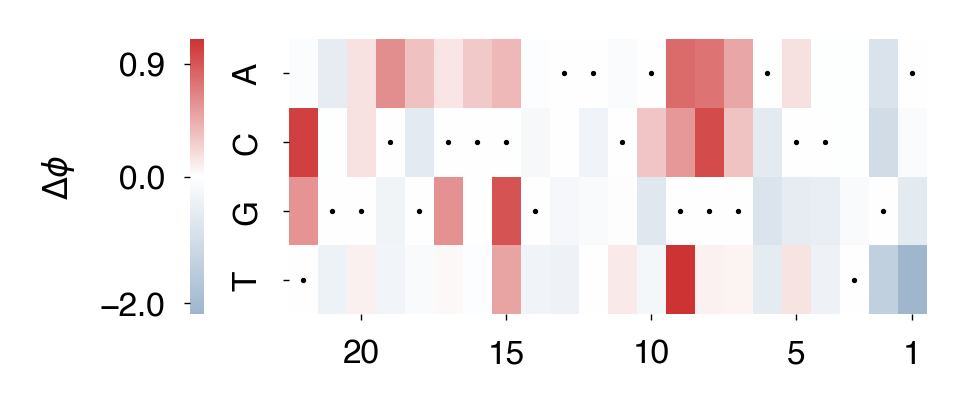

In [8]:
wt_seq = wts['Josh_match']
alph = np.array(['A','C','G','T'])
wt_oh = np.array(list(wt_seq))[:, None] == alph[None,:]

theta_dict = model.get_theta(gauge="user", x_wt=wt_seq)
rc_alt_size = rc_defaults.copy()
rc_alt_size["figure.figsize"] = (2.17, 0.87)
with rc_context(rc_alt_size):
    import matplotlib.colors as mcolors
    vcenter = 0
    vmin, vmax = theta_dict['theta_lc'].min(), theta_dict['theta_lc'].max()
    normalize = mcolors.TwoSlopeNorm(vcenter=vcenter, vmin=vmin, vmax=vmax)

    fig, ax = plt.subplots(nrows=1,ncols=1, gridspec_kw=dict(left=0.01,right=0.99,top=0.99,bottom=0.2))
    
    sns.heatmap(theta_dict['theta_lc'].T, yticklabels=theta_dict['alphabet'],
                cmap=heatmap_cmap,norm=normalize,cbar_kws={'label': '$\Delta \phi$',"ticks":[-2,0,0.9],'location':'left'},
                     ax=ax)
    pos, nt = np.where(wt_oh)
    plt.scatter(pos+0.5,nt+0.5, s=0.5, c='k')
    # plt.xlabel('Position')
    # ticks, labels = plt.xticks()
    ax.set_xticks([2.5, 7.5, 12.5, 17.5, 21.5], [20, 15, 10, 5, 1])
    plt.savefig(f'../figure_panels/main/MAVENN_heatmap_bilinear_norm.pdf', dpi=600)
    plt.show()

# Make all points panel

/var/folders/5_/tjkj20xs1zjbm1r6n07ccp4h0000gn/T/ipykernel_54944/1728770977.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'../figure_panels/main/rank_pointplot.pdf', dpi=600)
/var/folders/5_/tjkj20xs1zjbm1r6n07ccp4h0000gn/T/ipykernel_54944/1728770977.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'../figure_panels/main/rank_pointplot.pdf', dpi=600)
/Users/jackdesmarais/miniconda3/envs/TRf_transposon_silencing_MPRA/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


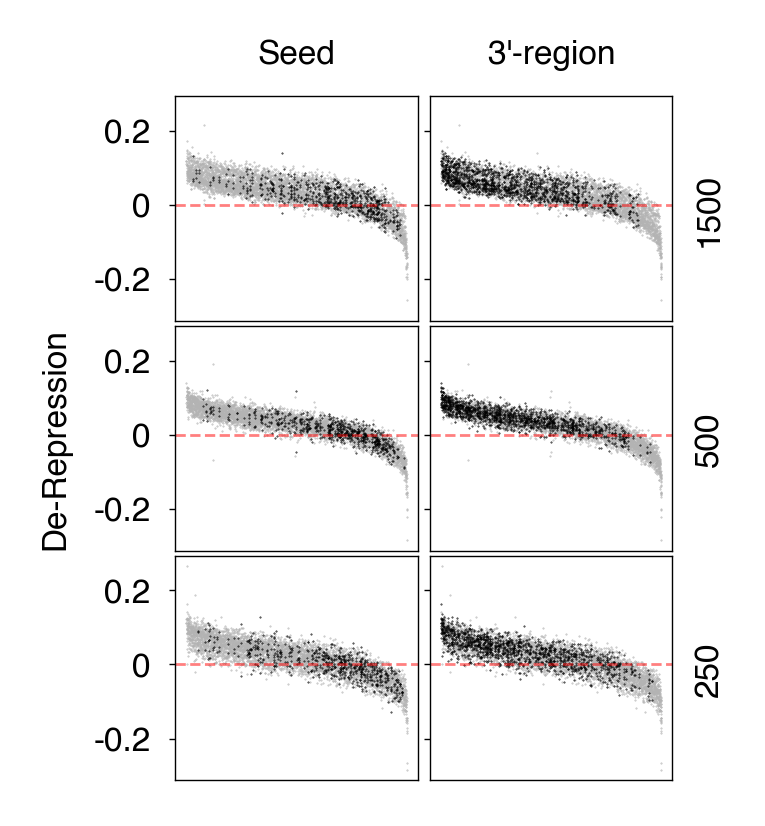

In [9]:
from scipy.stats import rankdata

comp = 'Josh_match'
mutation_num = (lib.fitness_frame['sequence'].values.reshape(-1,1).astype('U').view('U1') != np.array(list(wts[comp]))[None,:]).sum(axis=1)
seed_num = (lib.fitness_frame['sequence'].values.reshape(-1,1).astype('U').view('U1')[:,-7:-1] != np.array(list(wts[comp]))[None,-7:-1]).sum(axis=1)
p3_num = (lib.fitness_frame['sequence'].values.reshape(-1,1).astype('U').view('U1')[:,:-13] != np.array(list(wts[comp]))[None,:-13]).sum(axis=1)

seed_mut = (seed_num>0)&(mutation_num==seed_num)
p3_mut = (p3_num>0)&(mutation_num==p3_num)

rc_alt_size = rc_defaults.copy()
rc_alt_size["figure.figsize"] = (1.75,1.9)
with rc_context(rc_alt_size), sns.plotting_context({'lines.markersize':0.1, 'font.size':6, 
                                                    'axes.labelsize':6,'axes.titlesize':6,
                                                    'xtick.labelsize':6,'ytick.labelsize':6}):
    fig, axes = plt.subplots(ncols=2, nrows=3,sharex=True,sharey=True,gridspec_kw=dict(wspace=0.05, hspace=0.025,
                                                                                       left=0.2,
                                                                                       bottom=0.01,
                                                                                       right=0.91,
                                                                                       top=0.91))
    # plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0)
    # axes = gridspec.GridSpec(3, 2,wspace=0.025, hspace=0.05)

    for row, library in enumerate(['RNA1500','RNA500','RNA250']):
        cut = lib.fitness_frame.T[(lib.fitness_frame.columns.str.startswith(lib.fitness_measure)&lib.fitness_frame.columns.str.endswith(library))].T
        cut['Mutation number'] = mutation_num
        cut['Seed mutant'] = seed_mut
        cut["3' mutant"] = p3_mut
        cut = cut.set_index([cut.index,'Seed mutant',"3' mutant", 'Mutation number']).stack().reset_index().rename(columns={
            'level_0':'Sequence',
            'level_4':'Pool',
            0:'log$_{10}$(RNA/DNA)',
            })

        cut = cut.set_index(['Mutation number','Seed mutant',"3' mutant",'Sequence','Pool']).unstack('Pool') - cut.set_index(['Mutation number','Seed mutant',"3' mutant", 'Sequence', 'Pool']).unstack('Pool').loc[0].values
        rank = pd.Series(rankdata(-cut.mean(axis=1)), index=cut.index)
        cut=cut.stack('Pool').rename(columns={'log$_{10}$(RNA/DNA)':'De-Repression'})
        cut['Rank'] = rank
        cut = cut.reset_index()
        
        plt.sca(axes[row,0])
        if row ==0:
            plt.title('Seed')
        plt.scatter(cut['Rank'][~cut['Seed mutant']], cut['De-Repression'][~cut['Seed mutant']],
                    color='0.7')
        
        plt.scatter(cut['Rank'][cut['Seed mutant']], cut['De-Repression'][cut['Seed mutant']],
                    color='k')
        axes[row,0].set_yticks([-0.2,0,0.2],[-0.2,0,0.2])
        plt.axhline(0, c='r', alpha=0.5, linestyle='--')
        if row ==1:
            axes[row,0].set_ylabel('De-Repression')

        plt.sca(axes[row,1])
        if row ==0:
            plt.title("3'-region")
        plt.scatter(cut['Rank'][~cut["3' mutant"]], cut['De-Repression'][~cut["3' mutant"]],
                    color='0.7')
        
        plt.scatter(cut['Rank'][cut["3' mutant"]], cut['De-Repression'][cut["3' mutant"]],
                    color='k')
        
        axes[row,1].yaxis.set_label_position("right")
        axes[row,1].set_ylabel(f'{library[3:]}')
        plt.axhline(0, c='r', alpha=0.5, linestyle='--')
        
    plt.xticks([])
    
plt.savefig(f'../figure_panels/main/rank_pointplot.pdf', dpi=600)

plt.show()

# Make region stratification plot

,level_0,Seed mutant,3' mutant,Mutation number,level_4,0
0,0,False,False,11,pool1_RNA1500,-0.001132
1,0,False,False,11,pool1_RNA250,-0.010527
2,0,False,False,11,pool1_RNA500,0.011667
3,0,False,False,11,pool2_RNA1500,0.007936
4,0,False,False,11,pool2_RNA250,-0.010248
...,...,...,...,...,...,...
15997,1777,False,False,12,pool2_RNA250,0.038634
15998,1777,False,False,12,pool2_RNA500,0.040258
15999,1777,False,False,12,pool3_RNA1500,0.048989
16000,1777,False,False,12,pool3_RNA250,0.041715


,Sequence,Seed mutant,3' mutant,Mutation number,log$_{10}$(RNA/DNA),Pool,Library
0,0,False,False,11,-0.001132,pool1,RNA1500
1,0,False,False,11,-0.010527,pool1,RNA250
2,0,False,False,11,0.011667,pool1,RNA500
3,0,False,False,11,0.007936,pool2,RNA1500
4,0,False,False,11,-0.010248,pool2,RNA250
...,...,...,...,...,...,...,...
15997,1777,False,False,12,0.038634,pool2,RNA250
15998,1777,False,False,12,0.040258,pool2,RNA500
15999,1777,False,False,12,0.048989,pool3,RNA1500
16000,1777,False,False,12,0.041715,pool3,RNA250


/Users/jackdesmarais/miniconda3/envs/TRf_transposon_silencing_MPRA/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


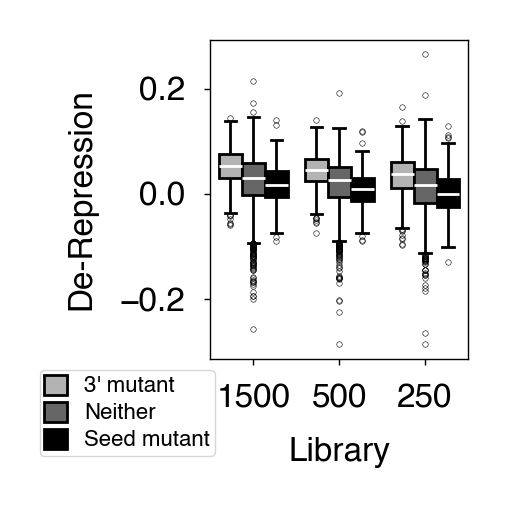

In [10]:
comp = 'Josh_match'
mutation_num = (lib.fitness_frame['sequence'].values.reshape(-1,1).astype('U').view('U1') != np.array(list(wts[comp]))[None,:]).sum(axis=1)
seed_num = (lib.fitness_frame['sequence'].values.reshape(-1,1).astype('U').view('U1')[:,-7:-1] != np.array(list(wts[comp]))[None,-7:-1]).sum(axis=1)
p3_num = (lib.fitness_frame['sequence'].values.reshape(-1,1).astype('U').view('U1')[:,:-13] != np.array(list(wts[comp]))[None,:-13]).sum(axis=1)

seed_mut = (seed_num>0)&(mutation_num==seed_num)
p3_mut = (p3_num>0)&(mutation_num==p3_num)

cut = lib.fitness_frame.T[lib.fitness_frame.columns.str.startswith(lib.fitness_measure)].T
cut.columns = cut.columns.str[len(lib.fitness_measure)+1:]
cut['Mutation number'] = mutation_num
cut['Seed mutant'] = seed_mut
cut["3' mutant"] = p3_mut

cut = cut.set_index([cut.index,'Seed mutant',"3' mutant", 'Mutation number']).stack().to_frame().reset_index()
display(cut)
cut = cut.rename(columns={
    'level_0':'Sequence',
    'level_4':'Replicate',
    0:'log$_{10}$(RNA/DNA)',
    })

cut['Pool'], cut['Library'] = zip(*cut['Replicate'].str.split('_'))
cut = cut.drop(columns=['Replicate'])
display(cut)
cut = cut.set_index(['Mutation number','Seed mutant',"3' mutant",'Sequence','Pool', 'Library']).unstack(['Pool','Library']) - cut.set_index(['Mutation number','Seed mutant',"3' mutant", 'Sequence', 'Pool', 'Library']).unstack(['Pool','Library']).loc[0].values
cut=cut.stack(['Pool','Library']).rename(columns={'log$_{10}$(RNA/DNA)':'De-Repression'}).reset_index()

cut = cut.replace({'Library': {'RNA1500': '1500', 'RNA500': '500', 'RNA250': '250'}}, inplace=False)

cut.loc[cut['Seed mutant']&cut['3\' mutant'],'Sequence Category'] = "Both"
cut.loc[cut['Seed mutant']&~cut['3\' mutant'],'Sequence Category'] = "Seed mutant"
cut.loc[~cut['Seed mutant']&cut['3\' mutant'],'Sequence Category'] = "3' mutant"
cut.loc[~cut['Seed mutant']&~cut['3\' mutant'],'Sequence Category'] = "Neither"

rc_alt_size = rc_defaults.copy()
rc_alt_size["figure.figsize"] = (1.25,1.25)
with rc_context(rc_alt_size), sns.plotting_context({'lines.markersize':0.1, 'font.size':6, 
                                                    'axes.labelsize':6,'axes.titlesize':6,
                                                    'xtick.labelsize':6,'ytick.labelsize':6}):
        w = 0.5
        p = sns.boxplot(data=cut, y='De-Repression', hue='Sequence Category', x='Library', 
                        hue_order=['3\' mutant','Neither','Seed mutant'],
                        order=['1500','500','250'],
                    palette=['0.7','0.4','k'], 
                    medianprops={"color": "white", "linewidth": w},
                    boxprops={"linewidth": w},
                    whiskerprops={"linewidth": w},
                    capprops={"linewidth": w},
                    legend=True)
        
        handles, labels = p.get_legend_handles_labels()
        legend = plt.legend(handles=handles, labels=labels, bbox_to_anchor=(0.06, -0.001), 
                            loc='upper right', fontsize=4, handlelength=1, handleheight=1, 
                            borderpad=0.2, labelspacing=0.2)
        
        plt.savefig(f'../figure_panels/main/boxplot_sequence_category_descending_square_width_{w}.pdf', dpi=600)
        plt.show()


# make the mutation number panel

/var/folders/5_/tjkj20xs1zjbm1r6n07ccp4h0000gn/T/ipykernel_54944/1901929372.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stats_df['ttest_corrected_pval'][mask] = false_discovery_control(stats_df['ttest_pval'][mask])


,ttest_pval,ttest_corrected_pval,ttest_Sig
Mutation number,,,
1,4.233864e-09,5.292329e-09,True
2,1.219068e-66,3.047669e-66,True
3,5.171669e-97,2.585835e-96,True
4,7.895747e-09,7.895747e-09,True
5,1.934961e-23,3.224934e-23,True


,Mutation number,Sequence,log$_{10}$(RNA/DNA),density
1045,5,1526,-0.125175,0.188068
175,2,529,-0.065842,0.308484
824,3,1588,-0.068616,0.344861
366,2,1551,-0.059771,0.484197
1016,5,1258,-0.086890,0.613779
...,...,...,...,...
478,3,313,0.044131,15.086484
608,3,788,0.043800,15.086507
568,3,650,0.043852,15.086748
623,3,858,0.043972,15.086955


/var/folders/5_/tjkj20xs1zjbm1r6n07ccp4h0000gn/T/ipykernel_54944/1901929372.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'../figure_panels/main/mutation_number_panel_full_box.pdf', dpi=600)


OG


/var/folders/5_/tjkj20xs1zjbm1r6n07ccp4h0000gn/T/ipykernel_54944/1901929372.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'../figure_panels/main/mutation_number_panel_full_box.pdf', dpi=600)
/Users/jackdesmarais/miniconda3/envs/TRf_transposon_silencing_MPRA/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


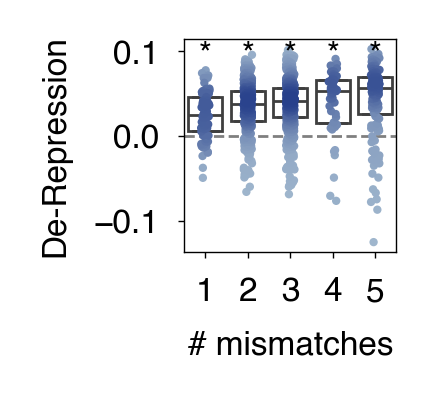

In [11]:
comp='Josh_match'

mutation_num = (lib.fitness_frame['sequence'].values.reshape(-1,1).astype('U').view('U1') != np.array(list(wts[comp]))[None,:]).sum(axis=1)

cut = lib.fitness_frame.T[lib.fitness_frame.columns.str.endswith('RNA1500')].T
cut['Mutation number'] = mutation_num
cut = cut.set_index([cut.index, 'Mutation number']).stack().reset_index().rename(columns={
    'level_0':'Sequence',
    'level_2':'Pool',
    0:'log$_{10}$(RNA/DNA)',
    })
cut = cut.set_index(['Mutation number','Sequence','Pool']).unstack('Pool') - cut.set_index(['Mutation number', 'Sequence', 'Pool']).unstack('Pool').loc[0].values

cut = cut.mean(axis=1).rename('log$_{10}$(RNA/DNA)').reset_index()
cut = cut[(cut['Mutation number']!=0)&(cut['Mutation number']<=5)]
cut = cut.reset_index().drop(columns='index')

stats_df = cut.groupby(['Mutation number'])['log$_{10}$(RNA/DNA)'].apply(ttester).rename('ttest_pval').to_frame()
mask = ~stats_df['ttest_pval'].isna()
stats_df['ttest_corrected_pval']=1
stats_df['ttest_corrected_pval'][mask] = false_discovery_control(stats_df['ttest_pval'][mask])
stats_df['ttest_Sig'] = stats_df['ttest_corrected_pval']<0.05
display(stats_df)

cut['density'] = cut.groupby('Mutation number', group_keys=False)['log$_{10}$(RNA/DNA)'].apply(make_density)
cut = cut.sort_values('density')
display(cut)
print('OG')
rc_alt_size = rc_defaults.copy()
rc_alt_size["figure.figsize"] = (0.9,0.9)
with rc_context(rc_alt_size):
    shift = 0.4
    fig, ax = plt.subplots(nrows=1,ncols=1, gridspec_kw=dict(left=shift,right=0.99,top=0.99,bottom=shift))
    p = sns.boxplot(data=cut, y='log$_{10}$(RNA/DNA)', x = 'Mutation number', boxprops=dict(fill=None),
                    showfliers=False,whis=0,capwidths=0.6, linewidth=0.5,
                ax=ax)
    p = sns.stripplot(data=cut, y='log$_{10}$(RNA/DNA)', x = 'Mutation number', size=1.5, hue='density', legend=False, palette=to_blue_cmap,
                    ax=ax)
    plt.sca(ax)
    plt.axhline(0, c='k', alpha=0.5, linestyle='--')

    ax.set_ylabel(f'De-Repression')
    ax.set_xlabel('# mismatches')

    for sig in stats_df[(stats_df.ttest_Sig)&(stats_df.index<=5)].index:
        plt.annotate('*',(sig-1,0.085), ha='center')


    plt.savefig(f'../figure_panels/main/mutation_number_panel_full_box.pdf', dpi=600)
    plt.show()

# Make sliding window panel

,level_0,Sequence_idx,Window,sequence,log$_{10}$(RNA/DNA),density
1007,1570,1570,6,TGGCGCCCGAACAGGGGCCTGA,-0.049273,0.641910
1006,1570,1570,5,TGGCGCCCGAACAGGGGCCTGA,-0.049273,0.683297
1005,1570,1570,4,TGGCGCCCGAACAGGGGCCTGA,-0.049273,0.705755
525,832,832,9,TGGCGCCCGAACGGGGACCTGA,-0.023490,0.747358
235,366,366,11,TGGCGCCCGAGAAGGGACCTGA,-0.011605,0.935529
...,...,...,...,...,...,...
219,338,338,7,TGGCGCCCGAACAGGAACCTGA,0.053356,29.963528
1020,1595,1595,7,TGGCGCCCGAACAGTCACCTGA,0.053455,30.020293
737,1152,1152,7,TGGCGCCCGAACAGTGACCTGA,0.053837,30.208662
42,69,69,7,TGGCGCCCGAACAAGGACCTGA,0.056112,30.343533


/var/folders/5_/tjkj20xs1zjbm1r6n07ccp4h0000gn/T/ipykernel_54944/3699859218.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stats_df['ttest_corrected_pval'][mask] = false_discovery_control(stats_df['ttest_pval'][mask])


,ttest_pval,ttest_corrected_pval,ttest_Sig
Window,,,
1,7.071333e-09,9.428443e-09,True
2,2.092470e-03,2.092470e-03,True
3,9.312908e-17,1.552151e-16,True
4,2.941764e-08,3.677205e-08,True
5,2.144006e-11,3.062866e-11,True
6,2.225153e-23,6.357581e-23,True
7,9.781662e-13,1.504871e-12,True
8,2.084802e-07,2.194528e-07,True
9,2.725955e-29,2.725955e-28,True


/var/folders/5_/tjkj20xs1zjbm1r6n07ccp4h0000gn/T/ipykernel_54944/3699859218.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'../figure_panels/main/Mutation_window_panel_full_box.pdf', dpi=600)
/var/folders/5_/tjkj20xs1zjbm1r6n07ccp4h0000gn/T/ipykernel_54944/3699859218.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'../figure_panels/main/Mutation_window_panel_full_box.pdf', dpi=600)
/Users/jackdesmarais/miniconda3/envs/TRf_transposon_silencing_MPRA/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


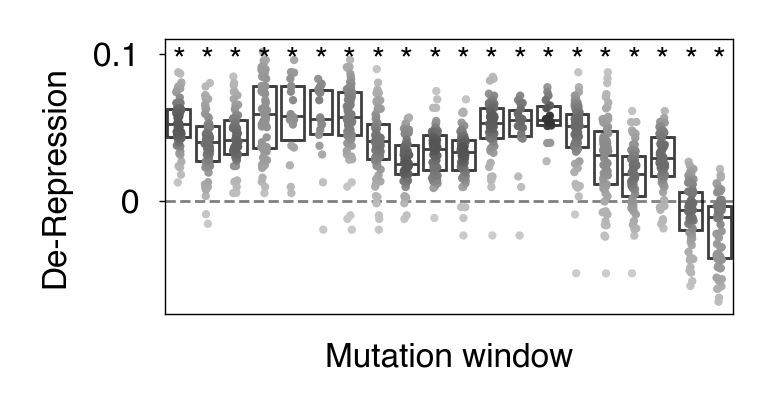

In [12]:
def def_window_muts(x, window=3):
    mut_pos = pd.Series(np.array(list(x))!=np.array(list(wts[comp])))[::-1]
    window_mask = mut_pos.rolling(window=window, center=True, min_periods=1).apply(lambda x: x.any()).astype(bool)

    out_mask = np.ones(len(mut_pos), dtype=bool)
    out_mask[:] = True
    for i in range(len(mut_pos)):
        if mut_pos.iloc[i]:
            out_mask[:max(0,i-(window//2))]= False
            out_mask[min(len(mut_pos),i+(window//2)+1):]= False
    mask = window_mask&out_mask
    pos = np.where(window_mask&out_mask)[0]
    return(pos)

col = 'RNA1500'

windows = lib.fitness_frame['sequence'].apply(def_window_muts).rename('Windows').reset_index().rename(columns={'index':'Sequence_idx'}).reset_index()

cut = lib.fitness_frame.T[(lib.fitness_frame.columns.str.endswith(col))|(lib.fitness_frame.columns=='sequence')].T
cut = cut.set_index(['sequence',cut.index]).stack().to_frame().reset_index().rename(columns={
    'level_1':'Sequence_idx',
    'level_2':'Replicate',
    0:'log$_{10}$(RNA/DNA)',
    })
cut['Replicate'] = cut['Replicate'].str[len(lib.fitness_measure)+1:]
cut['Pool'] = cut['Replicate'].str.split('_').str[0]
cut = cut.drop(columns=['Replicate'])
cut = cut.set_index(['sequence','Sequence_idx','Pool']).unstack('Pool') - cut.set_index(['sequence','Sequence_idx', 'Pool']).unstack('Pool').loc[wts['Josh_match']].values
cut = cut.mean(axis=1).rename('log$_{10}$(RNA/DNA)').to_frame().reset_index()
cut = pd.merge(right=cut, 
         left=windows,
          right_on='Sequence_idx', left_on='Sequence_idx')

cut = cut.explode('Windows')
cut=cut.rename(columns={'Windows':'Window'})
cut=cut[~cut['Window'].isna()]
cut=cut.rename(columns={col:'log$_{10}$(RNA/DNA)'})
cut = cut.reset_index().drop(columns='index')
cut['density'] = cut.groupby('Window', group_keys=False)['log$_{10}$(RNA/DNA)'].apply(make_density)
cut = cut.sort_values('density')
cut= cut[(cut.Window!=0)&(cut.Window!=21)]
display(cut)

stats_df = cut.groupby(['Window'])['log$_{10}$(RNA/DNA)'].apply(ttester).rename('ttest_pval').to_frame()
mask = ~stats_df['ttest_pval'].isna()
stats_df['ttest_corrected_pval']=1
stats_df['ttest_corrected_pval'][mask] = false_discovery_control(stats_df['ttest_pval'][mask])
stats_df['ttest_Sig'] = stats_df['ttest_corrected_pval']<0.05
display(stats_df)

rc_alt_size = rc_defaults.copy()
rc_alt_size["figure.figsize"] = (1.8,0.87)
with rc_context(rc_alt_size):
    shift = 0.2
    fig, ax = plt.subplots(nrows=1,ncols=1, gridspec_kw=dict(left=shift,right=0.99,top=0.99,bottom=shift))
    
    sns.boxplot(data=cut, y='log$_{10}$(RNA/DNA)', x = 'Window', boxprops=dict(fill=None),showfliers=False,whis=0,capwidths=0.6, linewidth=0.5,
                ax=ax)
    sns.stripplot(data=cut, y='log$_{10}$(RNA/DNA)', x = 'Window', size=1.5, hue='density',legend=False, palette=grey_cmap,#palette="crest",
                    ax=ax)
    plt.sca(ax)
    plt.axhline(0, c='k', alpha=0.5, linestyle='--')
    for sig in stats_df[stats_df.ttest_Sig].index:
        plt.annotate('*',(sig-1,0.095), ha='center',va='center')


    ax.invert_xaxis()
    ax.set_xticks([])
    ax.set_yticks([0,0.1],[0,0.1])
    ax.set_ylabel(f'De-Repression')
    ax.set_xlabel('Mutation window')
    plt.savefig(f'../figure_panels/main/Mutation_window_panel_full_box.pdf', dpi=600)
    plt.show()

# Make the mutant number region panel

/var/folders/5_/tjkj20xs1zjbm1r6n07ccp4h0000gn/T/ipykernel_54944/162919943.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cut['region'][(r_num>0)&(cut['Mutation number']==r_num)] = region


,sequence,region,Mutation number,De-repression,density
189,TCAGGCCCGAACAGGGACCTGA,3'-region,3,-0.015571,0.635857
330,TGGCGCCCGAACAGGATCCTGA,Seed,2,0.087640,0.870695
584,TGGCGCCCGACTGGGGACCTGA,Central,3,-0.004211,0.933036
798,TTTTGCCCGAACAGGGACCTGA,3'-region,3,-0.009036,0.960955
348,TGGCGCCCGAACAGGCTTCTGA,Seed,3,0.083638,0.974943
...,...,...,...,...,...
167,TAGAAGCCGAACAGGGACCTGA,3'-region,4,0.073122,24.389135
209,TGAAAGCCGAACAGGGACCTGA,3'-region,4,0.065141,24.650882
231,TGATTGCCGAACAGGGACCTGA,3'-region,4,0.065991,25.008404
185,TCACTGCCGAACAGGGACCTGA,3'-region,4,0.071395,25.189429


/Users/jackdesmarais/miniconda3/envs/TRf_transposon_silencing_MPRA/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1081: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/Users/jackdesmarais/miniconda3/envs/TRf_transposon_silencing_MPRA/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1081: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/var/folders/5_/tjkj20xs1zjbm1r6n07ccp4h0000gn/T/ipykernel_54944/162919943.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stats_df['ttest_corrected_pval'][mask] = false_discovery_control(stats_df['ttest_pval'][mask])


ttest_pval  ttest_corrected_pval  ttest_Sig
region    Mutation number                                               
3'-region 1                3.124465e-07          4.513117e-07       True
          2                3.783097e-52          2.459013e-51       True
          3                3.349591e-60          4.354468e-59       True
          4                2.116152e-11          3.929997e-11       True
          5                1.040722e-20          2.254899e-20       True
          6                6.173505e-23          1.605111e-22       True
          7                5.548450e-07          7.212986e-07       True
Central   1                7.327095e-04          7.937687e-04       True
          2                2.384219e-26          7.748711e-26       True
          3                1.856759e-36          8.045954e-36       True
Seed      1                3.170796e-01          3.170796e-01      False
          2                1.146219e-06          1.354623e-06       True
          3                8.865128e-11          1.440583e-10       True
          4                         NaN          1.000000e+00      False

/var/folders/5_/tjkj20xs1zjbm1r6n07ccp4h0000gn/T/ipykernel_54944/162919943.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'../figure_panels/main/Mutations_by_region_full_box.pdf', dpi=600)
/var/folders/5_/tjkj20xs1zjbm1r6n07ccp4h0000gn/T/ipykernel_54944/162919943.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'../figure_panels/main/Mutations_by_region_full_box.pdf', dpi=600)
/Users/jackdesmarais/miniconda3/envs/TRf_transposon_silencing_MPRA/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


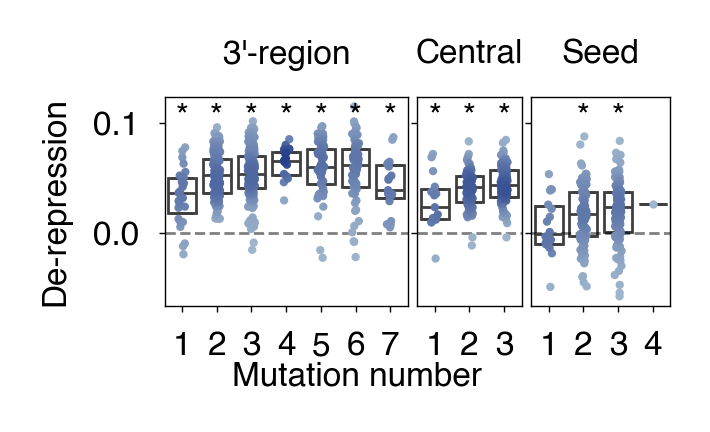

In [13]:
from matplotlib.colors import Normalize

comp = 'Josh_match'
regions = {
    'Seed':(2,7),
    'Central':(9,13),
    "3'-region":(14,22)
}

mutation_num = (lib.fitness_frame['sequence'].values.reshape(-1,1).astype('U').view('U1') != np.array(list(wts[comp]))[None,:]).sum(axis=1)

cut = lib.fitness_frame.T[(lib.fitness_frame.columns.str.endswith(col))|(lib.fitness_frame.columns=='sequence')].T
cut = cut.set_index([cut.index, 'sequence']).stack().to_frame().reset_index().rename(columns={
    'level_0':'Sequence_idx',
    'level_2':'Replicate',
    0:'log$_{10}$(RNA/DNA)'
    })
cut['Replicate'] = cut['Replicate'].str[len(lib.fitness_measure)+1:]
cut['Pool'] = cut['Replicate'].str.split('_').str[0]

cut['Mutation number'] = (cut['sequence'].values.reshape(-1,1).astype('U').view('U1') != np.array(list(wts[comp]))[None,:]).sum(axis=1)

cut['region'] = 'None'
for region, (start,end) in regions.items():
    r_num = (cut['sequence'].values.reshape(-1,1).astype('U').view('U1')[:,-end:-start+1] != np.array(list(wts[comp]))[None,-end:-start+1]).sum(axis=1)
    cut['region'][(r_num>0)&(cut['Mutation number']==r_num)] = region


cut = cut[['sequence','region', 'Mutation number','Pool', 'log$_{10}$(RNA/DNA)']]

cut = cut.set_index(['sequence','region', 'Mutation number','Pool']).unstack('Pool') - cut.set_index(['sequence','region', 'Mutation number','Pool']).unstack('Pool').loc[wts[comp]].values
cut = cut.mean(axis=1).rename('De-repression').reset_index()
cut = cut[(cut['Mutation number']!=0)&(cut['region']!='None')]
cut = cut.reset_index().drop(columns='index')
cut['density'] = cut.groupby(['Mutation number','region'], group_keys=False)['De-repression'].apply(make_density)
cut = cut.sort_values('density')

display(cut)

stats_df = cut.groupby(['region','Mutation number'])['De-repression'].apply(ttester).rename('ttest_pval').to_frame()
mask = ~stats_df['ttest_pval'].isna()
stats_df['ttest_corrected_pval']=1
stats_df['ttest_corrected_pval'][mask] = false_discovery_control(stats_df['ttest_pval'][mask])
stats_df['ttest_Sig'] = stats_df['ttest_corrected_pval']<0.05
display(stats_df)

rc_alt_size = rc_defaults.copy()
rc_alt_size["figure.figsize"] = (1.6,0.9)
with rc_context(rc_alt_size), sns.plotting_context({'lines.markersize':0.1, 'font.size':6, 
                                                    'axes.labelsize':6,'axes.titlesize':6,
                                                    'xtick.labelsize':6,'ytick.labelsize':6}):

    widths = [len(cut[cut['region']==region]['Mutation number'].unique()) for region in ["3'-region",'Central', 'Seed']]
    fig, axes = plt.subplots(ncols=3, gridspec_kw={'width_ratios':widths,'wspace':0.06, 'bottom':0.22,
                                                   'left':0.2,
                                                   'top':0.8,
                                                   'right':0.99}, sharey=True)
    # plt.subplots_adjust(bottom=0.14)

    norm = Normalize(vmin=cut.density.min(), vmax=cut.density.max())

    for region,ax in zip(["3'-region",'Central', 'Seed'],axes):
        sns.boxplot(data=cut[cut['region']==region], y='De-repression', x = 'Mutation number', boxprops=dict(fill=None),showfliers=False,whis=0,capwidths=0.6, linewidth=0.5,
                    ax=ax)
        sns.stripplot(data=cut[cut['region']==region], y='De-repression',size=1.5, x = 'Mutation number', hue='density',legend=False, palette=to_blue_cmap,hue_norm=norm,
                        ax=ax)
        plt.sca(ax)
        plt.axhline(0, c='k', alpha=0.5, linestyle='--')
        ax.set_title(region)
        plt.xlabel('')
        stats_df.loc[region]
        for sig in stats_df.loc[region][stats_df.loc[region].ttest_Sig].index:
            plt.annotate('*',(sig-1,0.105), ha='center',va='center')

    fig.text(0.5, 0, 'Mutation number', ha='center')
    plt.savefig(f'../figure_panels/main/Mutations_by_region_full_box.pdf', dpi=600)
    plt.show()